# Gradient Uniformity: Thermal or Deterministic?

**The Question:** During training, when most tokens are "wrong" (equally bad predictions), do they receive:
- **Uniform updates** (identical gradients → deterministic motion)
- **Thermal updates** (varied gradients → stochastic diffusion)

**The Test:** Examine step 1 of Lil Gatsby training:
- Batch size 32, vocab size 128 (ASCII)
- Expect <32 "correct" tokens (large gradients) due to letter repetition in "The Great Gatsby by F. Scott Fitzgerald"
- Expect ~96+ "wrong" tokens (small gradients)

**Hypothesis:** Wrong-token gradients will show **thermal variation** due to bfloat16 quantization noise, even if mathematically identical. This explains:
1. Crystal formation (f32→bf16 init quantization)
2. Crystal dissolution (bf16 gradient rounding accumulates)
3. Sparse connectivity (most crystals broke, ~20% survived)

## Parameters

In [38]:
# Paths
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9b_training_data.safetensors'

# Analysis
TRAINING_STEP = 1  # First actual training step
MAGNITUDE_THRESHOLD = None  # Auto-detect based on distribution

# Visualization
DPI = 200
COLORMAP = 'inferno'
RANDOM_SEED = 42

## Imports

In [39]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

## Device Detection

In [40]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Vocabulary

Lil Gatsby uses a 128-token ASCII vocabulary where `token_id = ord(char)`.  
No external tokenizer needed—decoding is just `chr(token_id)`.

In [41]:
print('✓ Using ASCII vocabulary (128 tokens)')
print('  Token ID = ASCII code')
print('  Decode: chr(token_id)')

✓ Using ASCII vocabulary (128 tokens)
  Token ID = ASCII code
  Decode: chr(token_id)


## Load Training Data

In [42]:
# Load all data from single file
data = load_file(TRAINING_DATA_PATH)

print('Loaded training data:')
print(f"  Keys: {list(data.keys())}")
print()

# Extract components
grads = data['grads']  # (100001, 128, 64)
dead_token_ids = data['dead_token_ids'].cpu().numpy()  # (50,)
live_token_ids = data['live_token_ids'].cpu().numpy()  # (78,)

print(f'Gradients: {grads.shape} ({grads.dtype})')
print(f'Dead tokens: {len(dead_token_ids)}')
print(f'Live tokens: {len(live_token_ids)}')
print(f'Total vocab: {len(dead_token_ids) + len(live_token_ids)}')
print()
print('Index mapping:')
print(f'  grads[step, 0:49, :] → dead tokens (ASCII {dead_token_ids[0]}-{dead_token_ids[-1]})')
print(f'  grads[step, 50:127, :] → live tokens (ASCII {live_token_ids[0]}-{live_token_ids[-1]})')

Loaded training data:
  Keys: ['dead_token_ids', 'live_token_ids', 'recorded_steps', 'adam_beta1', 'adam_beta2', 'embeddings', 'grads', 'init_sigma', 'learning_rate', 'logits', 'losses', 'momentum', 'variance', 'weight_decay', 'init_method_code']

Gradients: torch.Size([100001, 128, 64]) (torch.float32)
Dead tokens: 50
Live tokens: 78
Total vocab: 128

Index mapping:
  grads[step, 0:49, :] → dead tokens (ASCII 0-127)
  grads[step, 50:127, :] → live tokens (ASCII 10-122)


## Create Token ID Mapping

In [43]:
# Concatenate dead + live to match grads indexing
all_token_ids = np.concatenate([dead_token_ids, live_token_ids])

print(f'Token ID array: {len(all_token_ids)} entries')
print(f'  grads index → ASCII code mapping created')
print(f'  Example: grads[step, 0, :] corresponds to ASCII {all_token_ids[0]} = {repr(chr(all_token_ids[0]))}')

Token ID array: 128 entries
  grads index → ASCII code mapping created
  Example: grads[step, 0, :] corresponds to ASCII 0 = '\x00'


## Extract Step 1 Gradients

In [44]:
# Get gradients for step 1
step_grads = grads[TRAINING_STEP].to(device)  # Shape: (128, 64)

print(f'Step {TRAINING_STEP} gradients: {step_grads.shape}')

# Compute gradient magnitudes
grad_mags = torch.norm(step_grads, dim=1).cpu().numpy()

print(f'\nGradient magnitude stats:')
print(f'  Min: {grad_mags.min():.8f}')
print(f'  Max: {grad_mags.max():.8f}')
print(f'  Mean: {grad_mags.mean():.8f}')
print(f'  Median: {np.median(grad_mags):.8f}')

Step 1 gradients: torch.Size([128, 64])

Gradient magnitude stats:
  Min: 0.01130008
  Max: 1.25068057
  Mean: 0.09494927
  Median: 0.06170651


## Visualize Magnitude Distribution

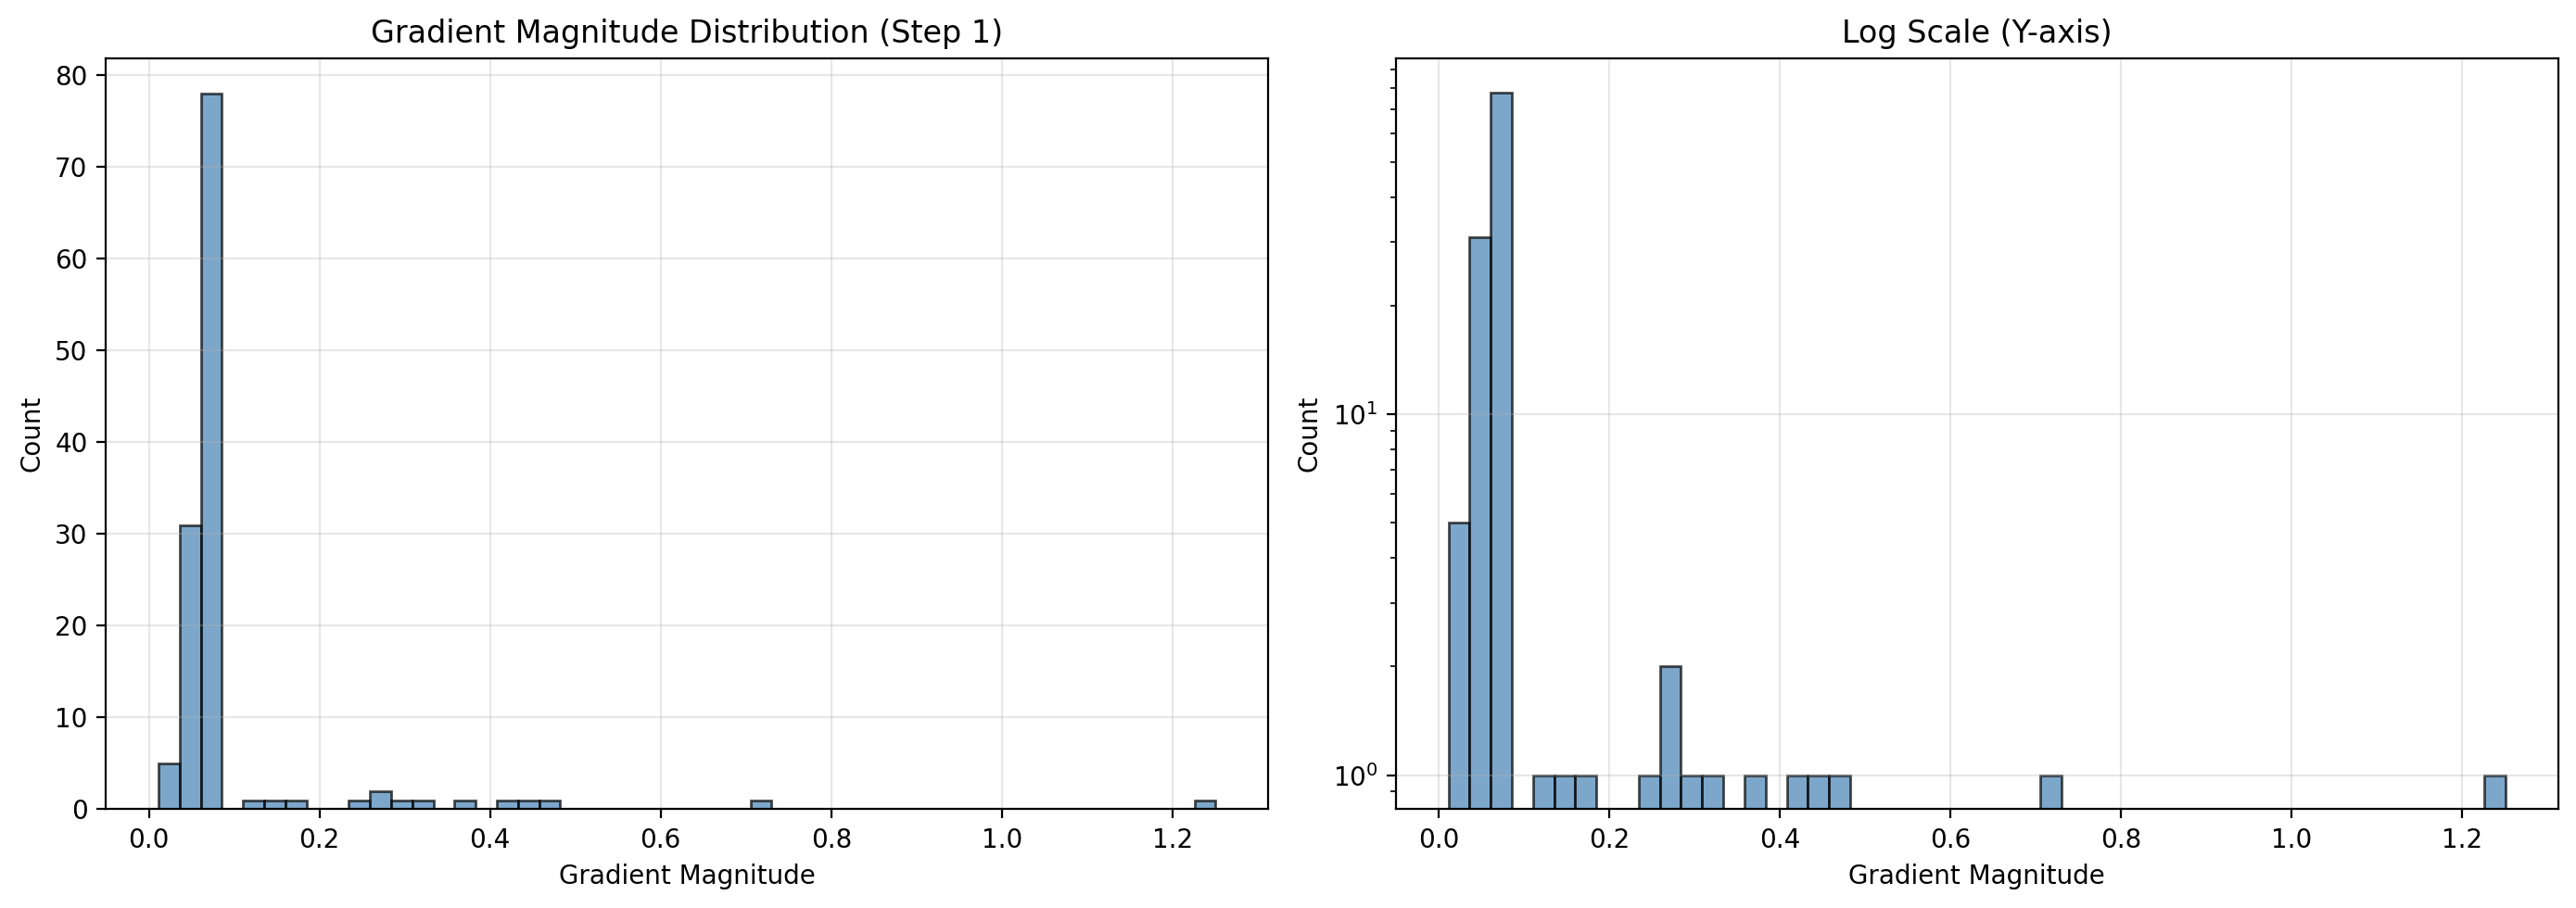

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Full histogram
axes[0].hist(grad_mags, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Gradient Magnitude')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Gradient Magnitude Distribution (Step {TRAINING_STEP})')
axes[0].grid(alpha=0.3)

# Right: Log scale
axes[1].hist(grad_mags, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Gradient Magnitude')
axes[1].set_ylabel('Count')
axes[1].set_title('Log Scale (Y-axis)')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Auto-detect Threshold

In [46]:
if MAGNITUDE_THRESHOLD is None:
    # Use 75th percentile as threshold
    threshold = np.percentile(grad_mags, 75)
    print(f'Auto-detected threshold: {threshold:.8f}')
    print(f'  (75th percentile of gradient magnitudes)')
else:
    threshold = MAGNITUDE_THRESHOLD
    print(f'Using manual threshold: {threshold}')

Auto-detected threshold: 0.06171234
  (75th percentile of gradient magnitudes)


## Separate Large vs Small Gradients

In [47]:
# Identify large and small gradient indices
large_mask = grad_mags > threshold
small_mask = ~large_mask

large_indices = np.where(large_mask)[0]
small_indices = np.where(small_mask)[0]

print(f'Large gradients: {len(large_indices)} tokens ({100*len(large_indices)/128:.1f}%)')
print(f'Small gradients: {len(small_indices)} tokens ({100*len(small_indices)/128:.1f}%)')
if len(large_indices) > 0:
    print(f'Ratio: {len(small_indices) / len(large_indices):.1f}× more small than large')

Large gradients: 27 tokens (21.1%)
Small gradients: 101 tokens (78.9%)
Ratio: 3.7× more small than large


## Analyze Large Gradients ("Correct" Tokens)

In [48]:
print('='*70)
print('LARGE GRADIENTS ("Correct" Tokens)')
print('='*70)
print()

if len(large_indices) == 0:
    print('No large gradients found. Threshold may be too high.')
else:
    # Get large gradient info
    large_mags = grad_mags[large_indices]
    large_token_ids = all_token_ids[large_indices]
    
    # Decode tokens using ASCII (token_id = ord(char))
    large_tokens_decoded = [chr(int(tid)) for tid in large_token_ids]
    
    print(f'Count: {len(large_indices)}')
    print()
    
    # Show magnitude stats
    print('Magnitude stats:')
    print(f'  Min: {large_mags.min():.8f}')
    print(f'  Max: {large_mags.max():.8f}')
    print(f'  Mean: {large_mags.mean():.8f}')
    print(f'  Std: {large_mags.std():.8f}')
    print()
    
    # List all tokens with magnitudes
    print('Tokens (sorted by magnitude):')
    sorted_pairs = sorted(zip(large_mags, large_tokens_decoded, large_token_ids), 
                         reverse=True)
    for mag, token, tid in sorted_pairs:
        # Show repr() for non-printable chars
        token_display = repr(token) if ord(token) < 32 or ord(token) > 126 else token
        print(f'  {mag:10.8f}  |{token_display}|  (ASCII {tid})')
    
    # Reconstruct the string
    print()
    print('Reconstructed string:')
    reconstructed = ''.join(large_tokens_decoded)
    print(f'  "{reconstructed}"')

print()
print('='*70)

LARGE GRADIENTS ("Correct" Tokens)

Count: 27

Magnitude stats:
  Min: 0.06171234
  Max: 1.25068057
  Mean: 0.23705091
  Std: 0.25988698

Tokens (sorted by magnitude):
  1.25068057  |%|  (ASCII 37)
  0.71995932  |]|  (ASCII 93)
  0.47279498  |X|  (ASCII 88)
  0.45347035  |o|  (ASCII 111)
  0.41228428  |j|  (ASCII 106)
  0.36216941  |i|  (ASCII 105)
  0.31147459  |n|  (ASCII 110)
  0.29615065  |c|  (ASCII 99)
  0.27843016  |m|  (ASCII 109)
  0.26488551  |d|  (ASCII 100)
  0.25124380  |[|  (ASCII 91)
  0.18320552  |g|  (ASCII 103)
  0.15591206  |p|  (ASCII 112)
  0.13276780  |'\x0b'|  (ASCII 11)
  0.08394464  |h|  (ASCII 104)
  0.08026249  |Z|  (ASCII 90)
  0.07052641  |r|  (ASCII 114)
  0.06463875  |a|  (ASCII 97)
  0.06177636  |'\x14'|  (ASCII 20)
  0.06177636  |'\x07'|  (ASCII 7)
  0.06172376  |>|  (ASCII 62)
  0.06172376  |'\x1c'|  (ASCII 28)
  0.06172376  |'\x15'|  (ASCII 21)
  0.06171235  |R|  (ASCII 82)
  0.06171235  |O|  (ASCII 79)
  0.06171235  |#|  (ASCII 35)
  0.06171234  |'\x

## Analyze Small Gradients ("Wrong" Tokens)

In [49]:
print('='*70)
print('SMALL GRADIENTS ("Wrong" Tokens)')
print('='*70)
print()

small_mags = grad_mags[small_indices]
small_grads = step_grads[small_indices].cpu()

print(f'Count: {len(small_indices)}')
print()

# Magnitude stats
print('Magnitude stats:')
print(f'  Min: {small_mags.min():.8f}')
print(f'  Max: {small_mags.max():.8f}')
print(f'  Mean: {small_mags.mean():.8f}')
print(f'  Std: {small_mags.std():.8f}')
print(f'  Coefficient of variation: {small_mags.std() / small_mags.mean():.4f}')
print()
print('='*70)

SMALL GRADIENTS ("Wrong" Tokens)

Count: 101

Magnitude stats:
  Min: 0.01130008
  Max: 0.06171234
  Mean: 0.05696169
  Std: 0.01032015
  Coefficient of variation: 0.1812



## Test for Exact Equality

In [50]:
print('Testing for exact equality among small gradients...')
print()

# Check if any are exactly equal
unique_grads = torch.unique(small_grads, dim=0)

print(f'Unique gradient vectors: {len(unique_grads)} / {len(small_grads)}')

if len(unique_grads) == len(small_grads):
    print('✓ All small gradients are UNIQUE (no exact duplicates)')
else:
    n_duplicates = len(small_grads) - len(unique_grads)
    print(f'⚠ Found {n_duplicates} duplicate gradient vectors')
    
    # Find which ones are duplicated
    grad_tuples = [tuple(g.numpy().round(10)) for g in small_grads]
    counter = Counter(grad_tuples)
    duplicates = {k: v for k, v in counter.items() if v > 1}
    
    print(f'\nDuplicate patterns:')
    for i, (pattern, count) in enumerate(sorted(duplicates.items(), key=lambda x: x[1], reverse=True)):
        if i < 5:  # Show first 5
            print(f'  {count} vectors share the same gradient')
        else:
            break

Testing for exact equality among small gradients...

Unique gradient vectors: 42 / 101
⚠ Found 59 duplicate gradient vectors

Duplicate patterns:
  28 vectors share the same gradient
  25 vectors share the same gradient
  5 vectors share the same gradient
  3 vectors share the same gradient
  2 vectors share the same gradient


## Cosine Similarity Analysis

In [51]:
print('Computing pairwise cosine similarities...')
print()

# Normalize gradient vectors
small_grads_norm = small_grads / small_grads.norm(dim=1, keepdim=True)

# Compute cosine similarity matrix
cosine_sim = small_grads_norm @ small_grads_norm.T

# Extract upper triangle (exclude diagonal)
triu_indices = torch.triu_indices(len(small_grads), len(small_grads), offset=1)
cosine_values = cosine_sim[triu_indices[0], triu_indices[1]].numpy()

print(f'Pairwise cosine similarities:')
print(f'  Min: {cosine_values.min():.8f}')
print(f'  Max: {cosine_values.max():.8f}')
print(f'  Mean: {cosine_values.mean():.8f}')
print(f'  Median: {np.median(cosine_values):.8f}')
print(f'  Std: {cosine_values.std():.8f}')
print()

# Check for near-parallel vectors
very_aligned = np.sum(cosine_values > 0.99)
somewhat_aligned = np.sum(cosine_values > 0.95)
print(f'Pairs with cosine > 0.99: {very_aligned} / {len(cosine_values)} ({100 * very_aligned / len(cosine_values):.2f}%)')
print(f'Pairs with cosine > 0.95: {somewhat_aligned} / {len(cosine_values)} ({100 * somewhat_aligned / len(cosine_values):.2f}%)')

Computing pairwise cosine similarities...

Pairwise cosine similarities:
  Min: -0.99920315
  Max: 1.00000024
  Mean: 0.77403927
  Median: 0.99997801
  Std: 0.63193882

Pairs with cosine > 0.99: 4385 / 5050 (86.83%)
Pairs with cosine > 0.95: 4480 / 5050 (88.71%)


## Visualize Cosine Similarity Distribution

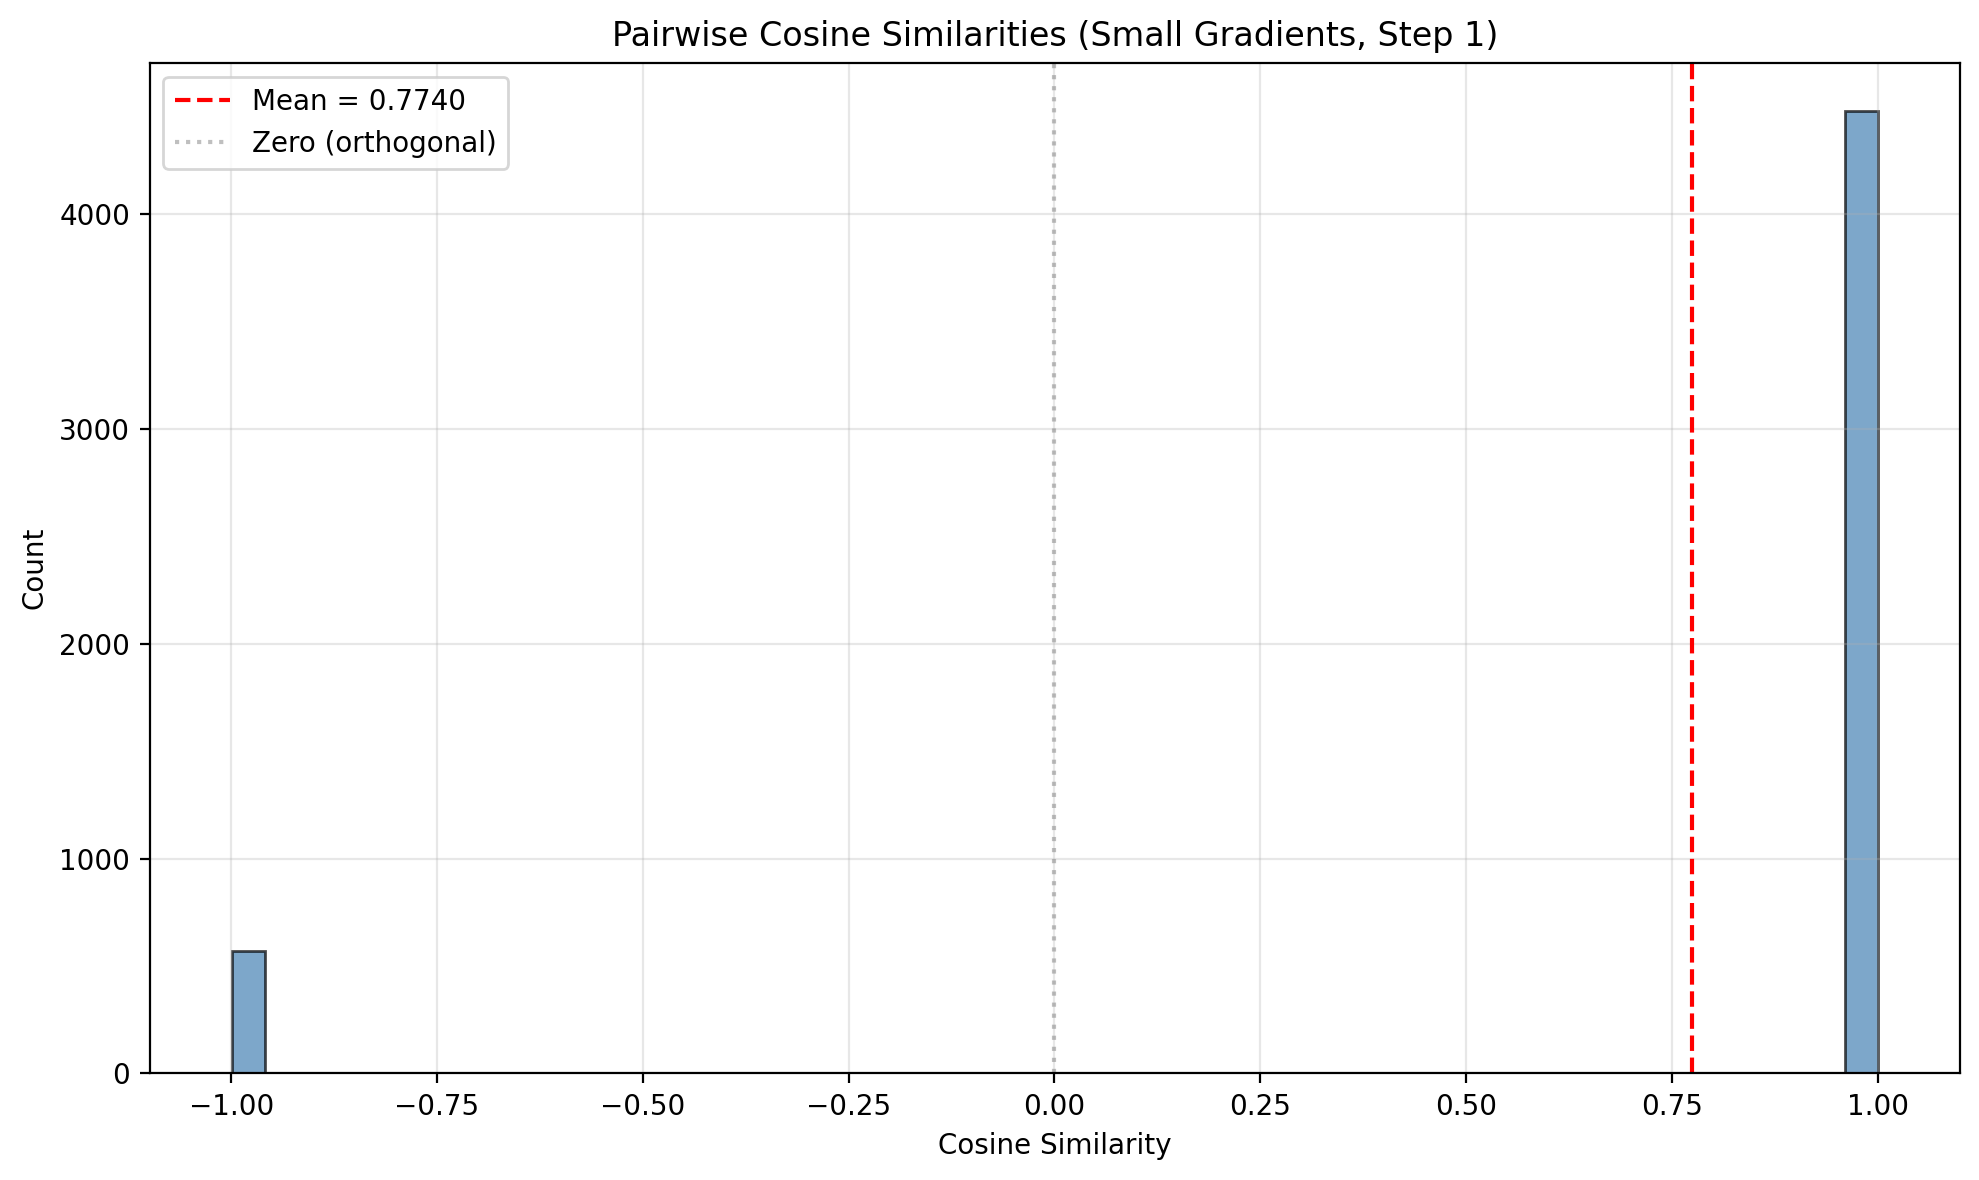

In [52]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(cosine_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(cosine_values.mean(), color='red', linestyle='--', 
           label=f'Mean = {cosine_values.mean():.4f}')
ax.axvline(0, color='gray', linestyle=':', alpha=0.5, label='Zero (orthogonal)')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title(f'Pairwise Cosine Similarities (Small Gradients, Step {TRAINING_STEP})')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Magnitude vs Cosine Scatter

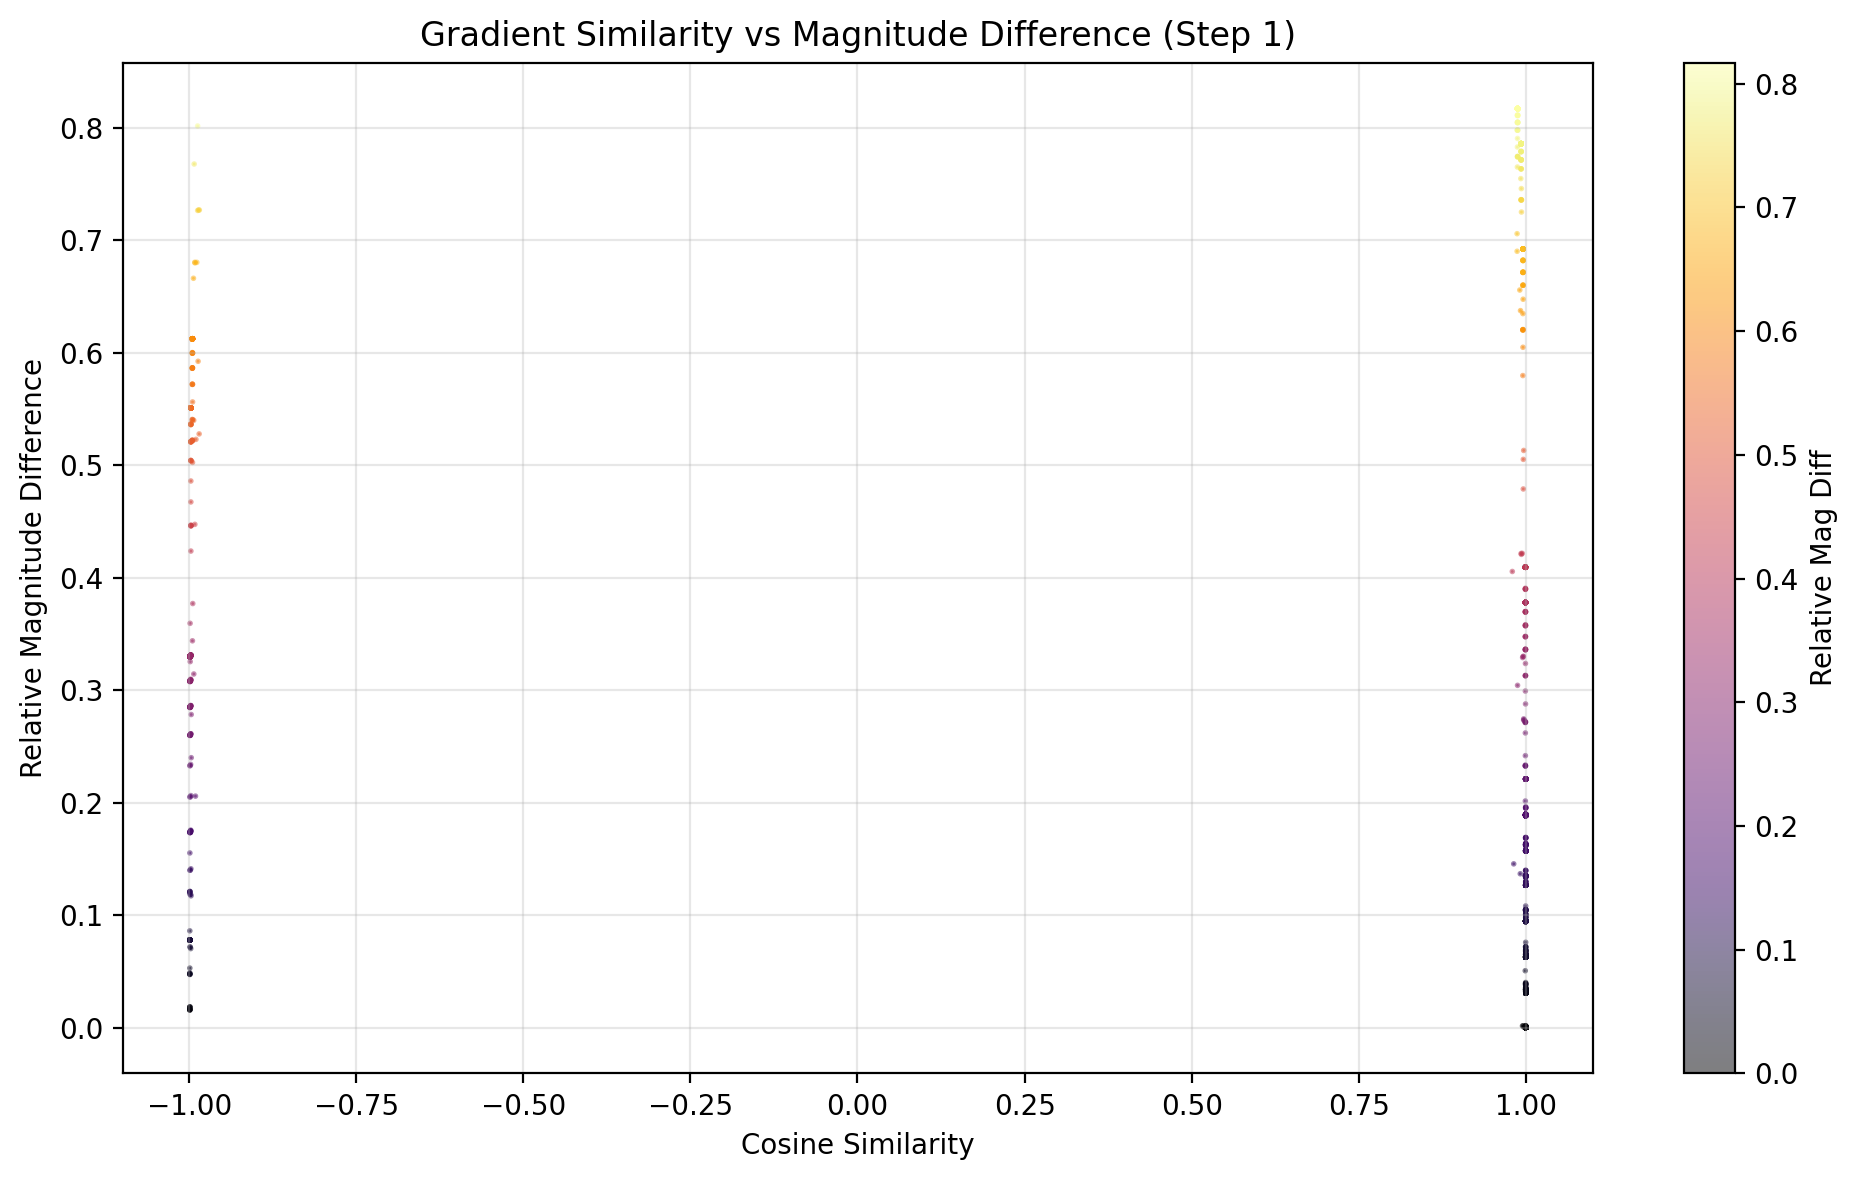

In [53]:
# For each pair, compute magnitude difference
mag_diffs = []
cos_sims = []

for i in range(len(small_indices)):
    for j in range(i+1, len(small_indices)):
        mag_i = small_mags[i]
        mag_j = small_mags[j]
        mag_diff = abs(mag_i - mag_j) / max(mag_i, mag_j)  # Relative difference
        cos_sim = cosine_sim[i, j].item()
        
        mag_diffs.append(mag_diff)
        cos_sims.append(cos_sim)

mag_diffs = np.array(mag_diffs)
cos_sims = np.array(cos_sims)

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

scatter = ax.scatter(cos_sims, mag_diffs, c=mag_diffs, cmap=COLORMAP, 
                    s=1, alpha=0.5)
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Relative Magnitude Difference')
ax.set_title(f'Gradient Similarity vs Magnitude Difference (Step {TRAINING_STEP})')
ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Relative Mag Diff')

plt.tight_layout()
plt.show()

## 2D Projection of Small Gradients

PCA explained variance:
  PC1: 0.9993
  PC2: 0.0002
  Total: 0.9994


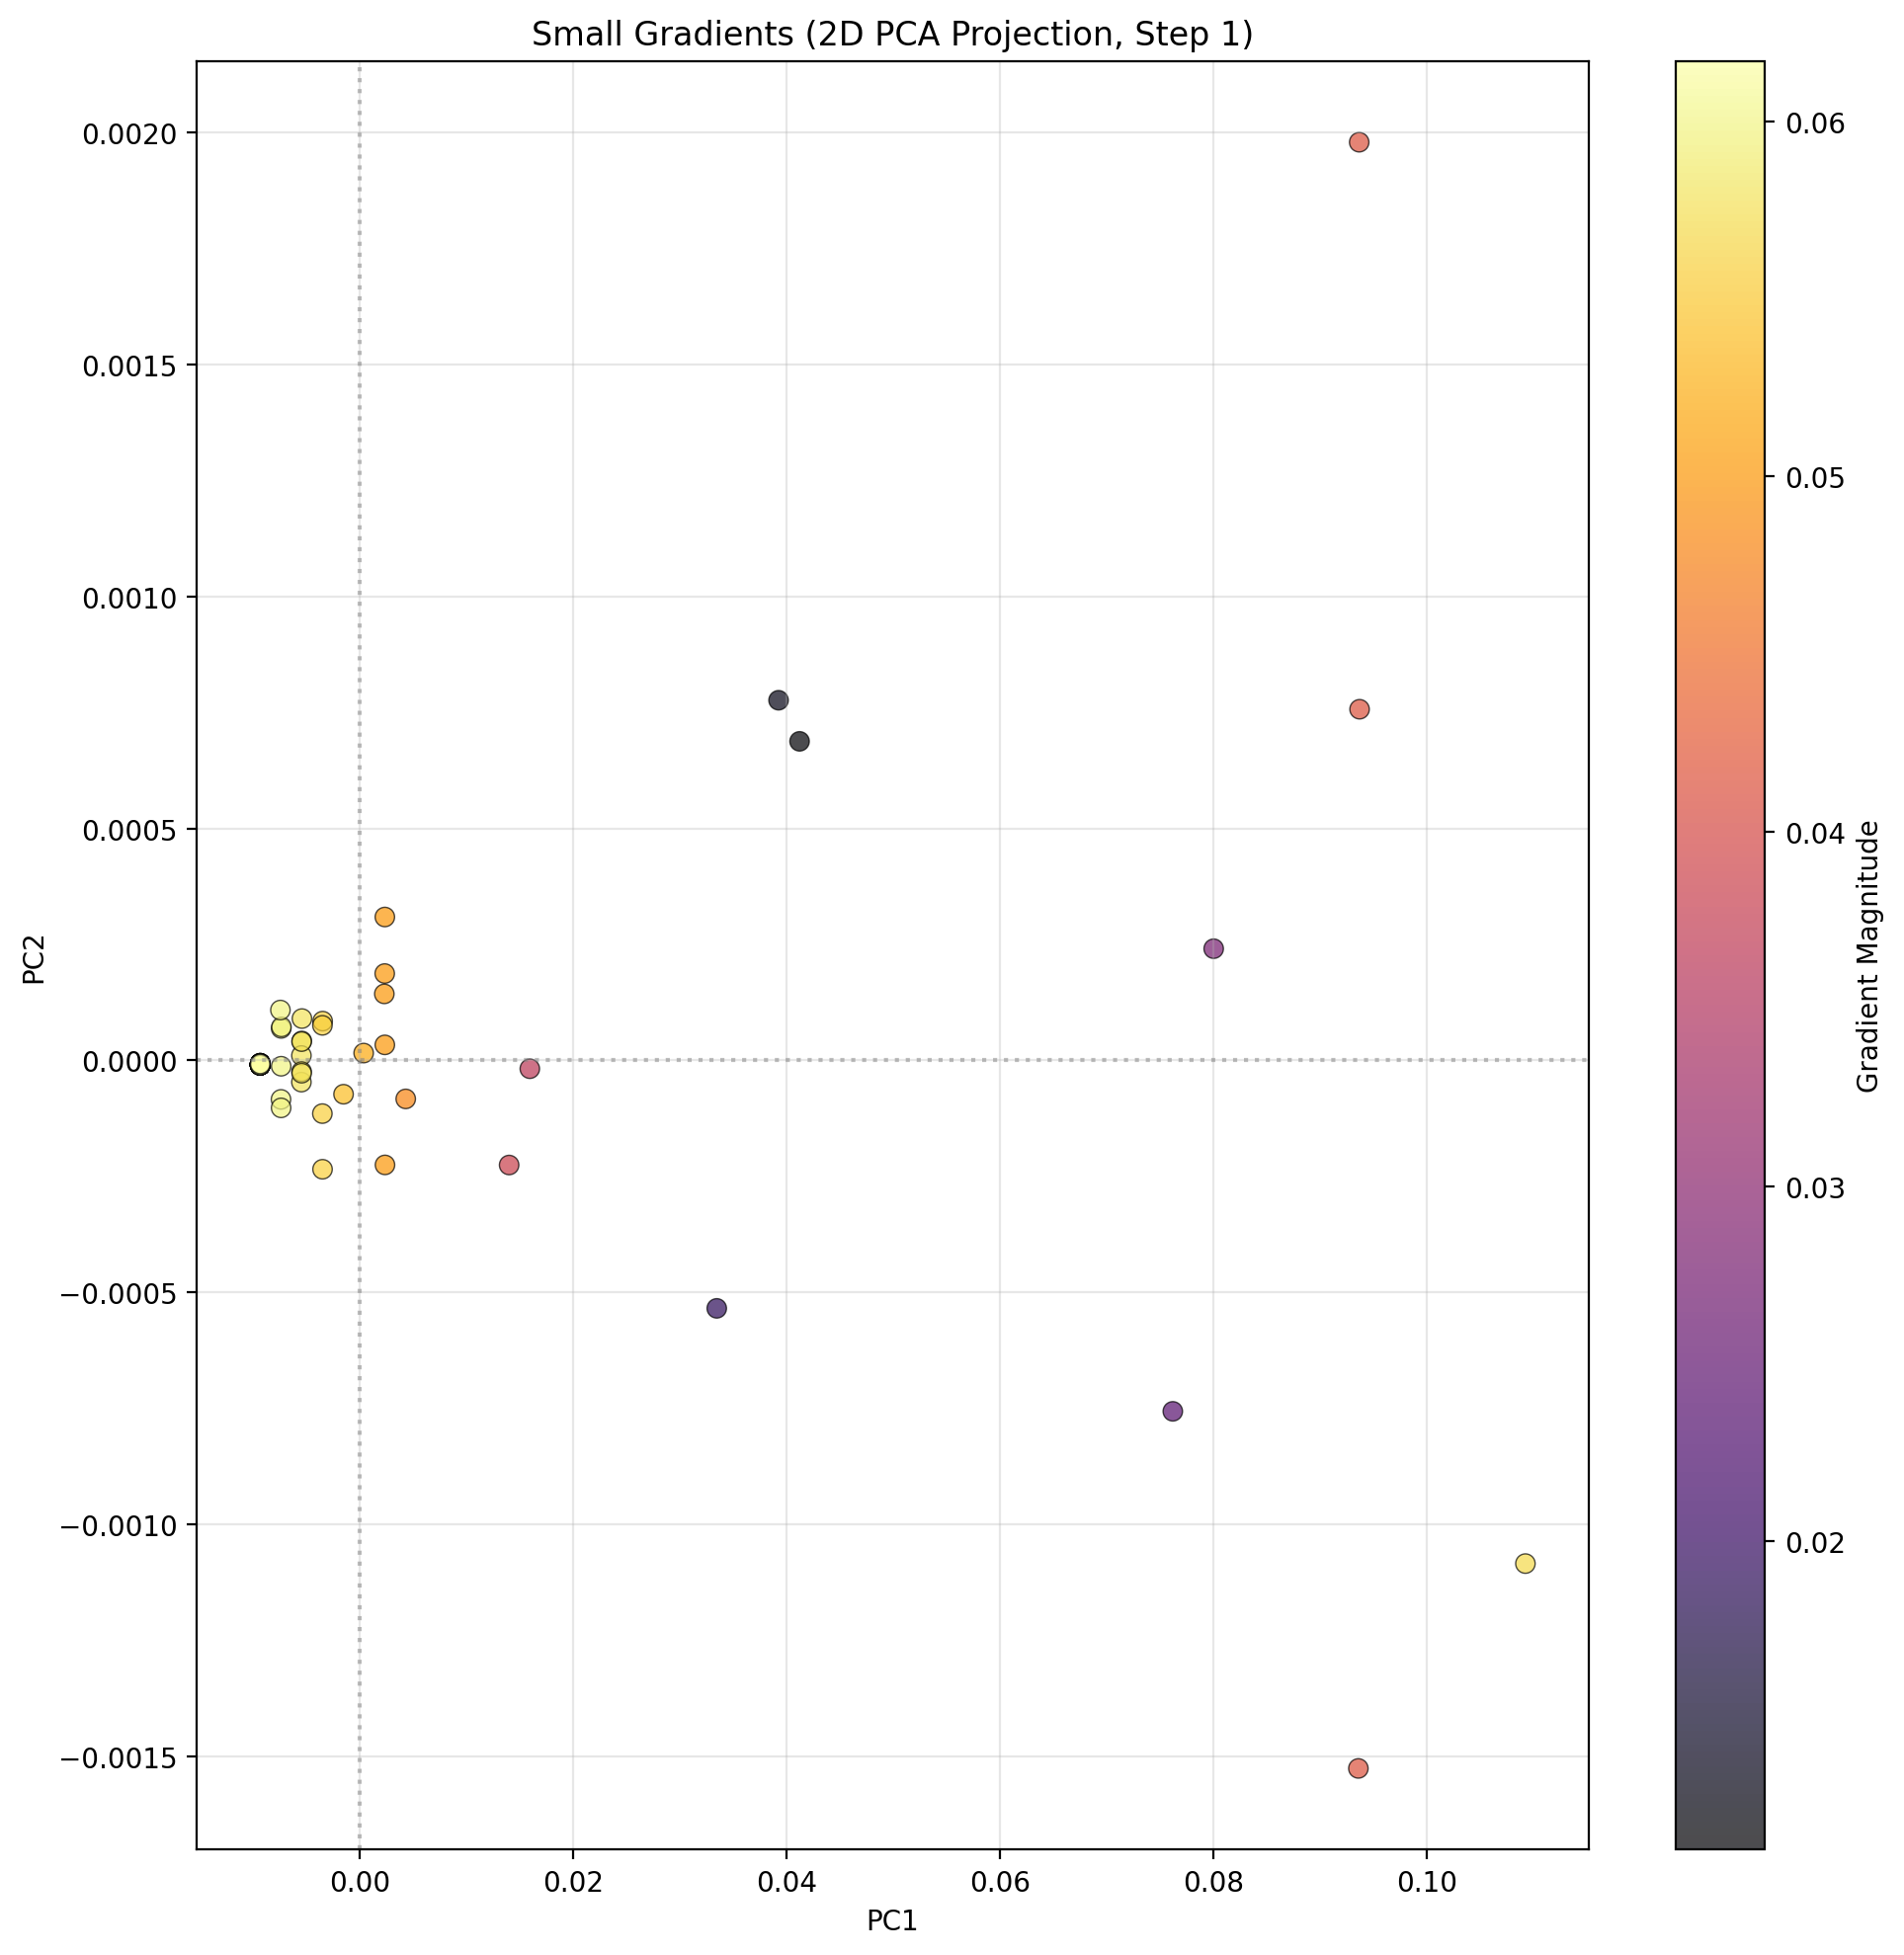

In [54]:
# Use PCA to project to 2D
pca = PCA(n_components=2, random_state=RANDOM_SEED)
small_grads_2d = pca.fit_transform(small_grads.numpy())

print(f'PCA explained variance:')
print(f'  PC1: {pca.explained_variance_ratio_[0]:.4f}')
print(f'  PC2: {pca.explained_variance_ratio_[1]:.4f}')
print(f'  Total: {pca.explained_variance_ratio_.sum():.4f}')

fig, ax = plt.subplots(figsize=(10, 10), dpi=DPI)

scatter = ax.scatter(small_grads_2d[:, 0], small_grads_2d[:, 1], 
                    c=small_mags, cmap=COLORMAP, s=50, alpha=0.7,
                    edgecolors='black', linewidths=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(f'Small Gradients (2D PCA Projection, Step {TRAINING_STEP})')
ax.grid(alpha=0.3)
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Gradient Magnitude')

plt.tight_layout()
plt.show()

## Conclusion

In [55]:
print('='*70)
print('SUMMARY: GRADIENT UNIFORMITY TEST')
print('='*70)
print()
print(f'Step: {TRAINING_STEP}')
print(f'Threshold: {threshold:.8f}')
print()
print(f'Large gradients ("correct" tokens): {len(large_indices)}')
if len(large_indices) > 0:
    print(f'  Magnitude range: {large_mags.min():.8f} to {large_mags.max():.8f}')
    print(f'  Decoded string: "{reconstructed}"')
print()
print(f'Small gradients ("wrong" tokens): {len(small_indices)}')
print(f'  Magnitude range: {small_mags.min():.8f} to {small_mags.max():.8f}')
print(f'  Magnitude CV: {small_mags.std() / small_mags.mean():.4f}')
print(f'  Unique vectors: {len(unique_grads)} / {len(small_grads)}')
print(f'  Mean cosine similarity: {cosine_values.mean():.6f}')
print()

# Verdict
if len(unique_grads) == len(small_grads) and cosine_values.mean() < 0.5:
    print('✓ THERMAL REGIME: Gradients are diverse and uncorrelated')
    print('  → bfloat16 quantization creates stochastic variation')
    print('  → Explains crystal dissolution during training')
elif cosine_values.mean() > 0.95:
    print('✓ UNIFORM REGIME: Gradients are nearly parallel')
    print('  → All wrong tokens move together')
    print('  → Crystals should remain stable')
else:
    print('⚠ MIXED REGIME: Some correlation but significant variation')
    print('  → Partial uniformity with thermal noise')
    print(f'  → Mean cosine = {cosine_values.mean():.4f} suggests moderate alignment')

print()
print('='*70)

SUMMARY: GRADIENT UNIFORMITY TEST

Step: 1
Threshold: 0.06171234

Large gradients ("correct" tokens): 27
  Magnitude range: 0.06171234 to 1.25068057
  Decoded string: "#%>ORXZ[]acdghijmnopr"

Small gradients ("wrong" tokens): 101
  Magnitude range: 0.01130008 to 0.06171234
  Magnitude CV: 0.1812
  Unique vectors: 42 / 101
  Mean cosine similarity: 0.774039

⚠ MIXED REGIME: Some correlation but significant variation
  → Partial uniformity with thermal noise
  → Mean cosine = 0.7740 suggests moderate alignment

